In [9]:
import torch
import numpy as np
import sys
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

import torch_harmonics as th

sys.path.append('/eagle/MDClimSim/mjp5595/ml4dvar/')
from stormer.varsStormer import varsStormer
from stormer.stormer_utils_pangu import StormerWrapperPangu

In [10]:
def get_forecast_h5(forecast_dir,idx,hour_diff):
    mode = 'r'
    file = os.path.join(forecast_dir,'norm_{:0>4d}.h5'.format(idx))
    print('forecast file :',file)
    f = h5py.File(file, mode)
    preds = np.array(f[str(hour_diff)][:],dtype=np.double)
    f.close()
    return preds 

def load_era5(era5_dir,idx,hour_diff,year,vars_stormer):
    mode = 'r'
    file_num = idx + (hour_diff // 6)
    file = os.path.join(era5_dir,'{}_{:0>4d}.h5'.format(year,file_num))
    print('era5 file :',file)
    f = h5py.File(file, mode)

    data_np = np.zeros((len(vars_stormer),128,256))
    for i,var in enumerate(vars_stormer):
        data_np[i] = f['input/{}'.format(var)][:]
    return data_np

def norm_era5(data_np,stormer_wrapper):
    data_torch = torch.from_numpy(data_np)
    data_torch_norm = stormer_wrapper.inp_transform(data_torch)
    data_np_norm = data_torch_norm.numpy()
    return data_np_norm

def norm(x_np,stormer_wrapper):
    x_torch = torch.from_numpy(x_np)
    x_torch_denorm = stormer_wrapper.inp_transform(x_torch)
    return x_torch_denorm

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

save_dir = '/eagle/MDClimSim/mjp5595/ml4dvar/stormer/data/'

vars_stormer = varsStormer().vars_stormer
stormer_wrapper = StormerWrapperPangu(
    root_dir='/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/',
    variables=vars_stormer,
    net=None,
    base_lead_time=[6],
    )

date_idx = 0
forecast_dir = '/eagle/MDClimSim/mjp5595/data/stormer/stormer_forecasts_2017_norm/'
era5_dir = '/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/'

sht = th.RealSHT(128, 256, grid = 'equiangular').to(device)
inv_sht = th.InverseRealSHT(128, 256, grid = 'equiangular').to(device)

files_norm = glob.glob(forecast_dir+'norm_????.h5')

hour_diff = 12
pred_start_idxs = [0,2]

checkpoint model loaded


In [12]:
#for psi in pred_start_idxs:
psi = pred_start_idxs[0]

#################################################################################
sh_coeffs_norm = []
hf_diff_norm = []
sh_coeffs_norm_rev = []
hf_diff_norm_rev = []

#for i in range(0,len(files_norm)):
i = 0
#print('hour_diff, i :',hour_diff,i)
try:
    preds = get_forecast_h5(forecast_dir,i,hour_diff=hour_diff)
    ground_truth_raw = load_era5(era5_dir,i,hour_diff,2017,vars_stormer)
    ground_truth = norm_era5(ground_truth_raw,stormer_wrapper)
except:
    print('skipping file due to h5 error',files_norm[i])

diff_norm = preds - ground_truth
diff_norm = torch.from_numpy(diff_norm).to(device)
sh_diff_norm = sht(diff_norm)
print('sh_diff_norm.shape :',sh_diff_norm.shape)
diff_hf_norm = diff_norm - inv_sht(sh_diff_norm)
# TODO why only take the first index here??
sh_coeffs_norm.append(np.real(sh_diff_norm[:, :, 0].cpu().numpy()))
hf_diff_norm.append(diff_hf_norm.cpu().numpy())

diff_norm_rev = ground_truth - preds
diff_norm_rev = torch.from_numpy(diff_norm_rev).to(device)
sh_diff_norm_rev = sht(diff_norm_rev)
print('sh_diff_rev_norm.shape :',sh_diff_norm_rev.shape)
diff_hf_norm_rev = diff_norm_rev - inv_sht(sh_diff_norm_rev)
sh_coeffs_norm_rev.append(np.real(sh_diff_norm_rev[:, :, 0].cpu().numpy()))
hf_diff_norm_rev.append(diff_hf_norm_rev.cpu().numpy())

sh_coeffs_norm = np.array(sh_coeffs_norm)
hf_diff_norm = np.array(hf_diff_norm)
sh_var_norm = np.var(sh_coeffs_norm[:], axis = 0)
hf_var_norm = np.var(hf_diff_norm[:], axis = 0)
#np.save(os.path.join(save_dir,'sh_{}hr_stormer_vs_era5_{:0>2d}.npy'.format(hour_diff,6*psi)), sh_var_norm)
#np.save(os.path.join(save_dir,'hf_{}hr_stormer_vs_era5_{:0>2d}.npy'.format(hour_diff,6*psi)), hf_var_norm)

sh_coeffs_norm_rev = np.array(sh_coeffs_norm_rev)
hf_diff_norm_rev = np.array(hf_diff_norm_rev)
sh_var_norm_rev = np.var(sh_coeffs_norm_rev[:], axis = 0)
hf_var_norm_rev = np.var(hf_diff_norm_rev[:], axis = 0)
#np.save(os.path.join(save_dir,'sh_{}hr_stormer_vs_era5_{:0>2d}_rev.npy'.format(hour_diff,6*psi)), sh_var_norm_rev)
#np.save(os.path.join(save_dir,'hf_{}hr_stormer_vs_era5_{:0>2d}_rev.npy'.format(hour_diff,6*psi)), hf_var_norm_rev)

forecast file : /eagle/MDClimSim/mjp5595/data/stormer/stormer_forecasts_2017_norm/norm_0000.h5
era5 file : /eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/train/2017_0002.h5
sh_diff_norm.shape : torch.Size([69, 128, 129])
sh_diff_rev_norm.shape : torch.Size([69, 128, 129])


In [1]:
import math
import numpy as np
import torch

from torch_harmonics.quadrature import legendre_gauss_weights
#from torch_harmonics.legendre import legpoly, clm
from torch_harmonics.legendre import clm
from torch_harmonics import RealSHT, InverseRealSHT
  
import matplotlib.pyplot as plt
from plotting_thUtils import plot_sphere

In [2]:
nlat = 128
nlon = 2*nlat
lmax = mmax = nlat

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax)

In [3]:
nmodes = int(lmax * (lmax+1) / 2)
e = torch.zeros(nmodes, lmax, mmax, dtype=torch.complex64)
e_neg = torch.zeros(nmodes, lmax, mmax, dtype=torch.complex64)

In [4]:
midx = lambda l,m : l*(l+1)//2 + m

for l in range(lmax):
    for m in range(l+1):
        #print('l,m,midx(l,m) : {},{},{}'.format(l,m,midx(l,m)))
        e[midx(l,m), l, m] = 1.0
        e_neg[midx(l,m), l, -m] = 1.0

l,m,midx(l,m) : 0,0,0
l,m,midx(l,m) : 1,0,1
l,m,midx(l,m) : 1,1,2
l,m,midx(l,m) : 2,0,3
l,m,midx(l,m) : 2,1,4
l,m,midx(l,m) : 2,2,5
l,m,midx(l,m) : 3,0,6
l,m,midx(l,m) : 3,1,7
l,m,midx(l,m) : 3,2,8
l,m,midx(l,m) : 3,3,9
l,m,midx(l,m) : 4,0,10
l,m,midx(l,m) : 4,1,11
l,m,midx(l,m) : 4,2,12
l,m,midx(l,m) : 4,3,13
l,m,midx(l,m) : 4,4,14
l,m,midx(l,m) : 5,0,15
l,m,midx(l,m) : 5,1,16
l,m,midx(l,m) : 5,2,17
l,m,midx(l,m) : 5,3,18
l,m,midx(l,m) : 5,4,19
l,m,midx(l,m) : 5,5,20
l,m,midx(l,m) : 6,0,21
l,m,midx(l,m) : 6,1,22
l,m,midx(l,m) : 6,2,23
l,m,midx(l,m) : 6,3,24
l,m,midx(l,m) : 6,4,25
l,m,midx(l,m) : 6,5,26
l,m,midx(l,m) : 6,6,27
l,m,midx(l,m) : 7,0,28
l,m,midx(l,m) : 7,1,29
l,m,midx(l,m) : 7,2,30
l,m,midx(l,m) : 7,3,31
l,m,midx(l,m) : 7,4,32
l,m,midx(l,m) : 7,5,33
l,m,midx(l,m) : 7,6,34
l,m,midx(l,m) : 7,7,35
l,m,midx(l,m) : 8,0,36
l,m,midx(l,m) : 8,1,37
l,m,midx(l,m) : 8,2,38
l,m,midx(l,m) : 8,3,39
l,m,midx(l,m) : 8,4,40
l,m,midx(l,m) : 8,5,41
l,m,midx(l,m) : 8,6,42
l,m,midx(l,m) : 8,7,4

In [5]:
print('e.shape :',e.shape)
vdm = isht(e)

e.shape : torch.Size([8256, 128, 128])


In [5]:
print('e_neg.shape :',e_neg.shape)
vdm_neg = isht(e_neg)

e_neg.shape : torch.Size([8256, 128, 128])


: 

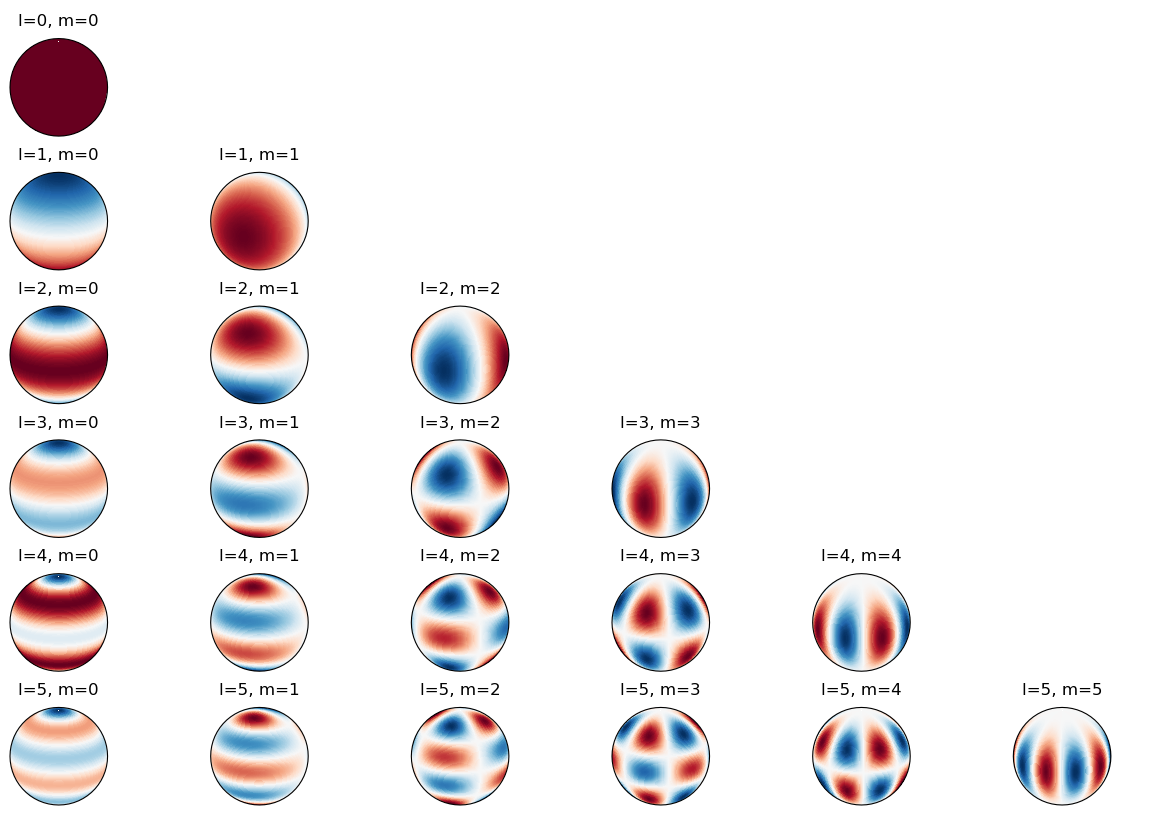

In [22]:
plt_lmax = 6

fig = plt.figure(layout='constrained', figsize=(12, 8))
subfigs = fig.subfigures(plt_lmax, plt_lmax)

for l in range(plt_lmax):
    for m in range(l+1):
        plot_sphere(vdm[midx(l,m)], fig=subfigs[l, m], title=f"l={l}, m={m}")

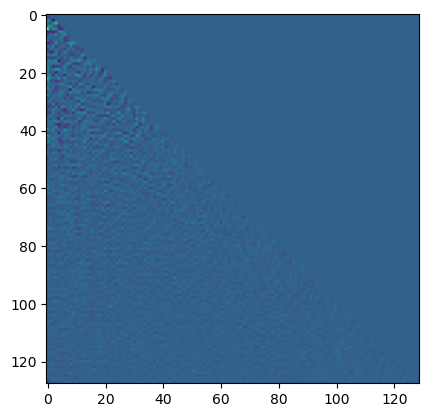

In [8]:
plt.imshow(np.real(sh_diff_norm[0]))
